In [1]:
from typing import List
import numpy as np
from sage.all import *
_=singular.lib('sing.lib')
singular.eval('LIB "critic01.lib"')

'// ** loaded critic01.lib (0.01,2002/02/11")'

In [2]:
class LefschetzFibration:
    def __init__(self, variables: List[Expression], domain_eq: Expression, fibration_eq: Expression) -> None:
        self.variables = variables
        self.domain = domain_eq
        self.fibration = fibration_eq
    
    def __call__(self, argument):
        return self.fibration.subs(argument) 
    
    def get_critical_points(self):
        """Returns the set of critical points."""
        G = self.domain
        f = self.fibration
        a = self.variables[-1]
        variables = self.variables[:-1]

        constraints = [G==0]
        constraints.extend([G.diff(variable) == a*f.diff(variable) for variable in variables])
        
        points = solve(constraints, self.variables)

        return points
    
    def get_critical_values(self):
        "Returns the set of critical values."
        crits = self.get_critical_points()
        return [self.__call__(x) for x in crits]
    
    def get_fibre(self, point, variable=None): 
        """Returns the definig equation (or equations) for the fibre over 'point' as a list. Specify 'variable'
        to solve the equation 'f = t' for the variable specified. If no variable is chosen,
        the first one is taken by default."""
        if variable is None:
            variable = self.variables[0]

        # Solve {f == t} for the specified variable
        solved_eqns = solve(self.fibration == point, variable)

        # Substitute in the defining equation for the domain

        return [self.domain.subs(eqn.simplify()) for eqn in solved_eqns]

    def milnor_number(self, point):
        """Returns the Milnor number of the fibre over 'point'. The fibre should be generic, so the function will return 
        an error if 'point' is a critical value."""

        fibre = self.get_fibre(point)

        poly = fibre[0] - point

        occuring_variables = []
        for var in self.variables:
            if str(var) in str(poly):
                occuring_variables.append(var)

        varstring = ', '.join(str(var) for var in occuring_variables)
        varstring = f'({varstring})'

        ring = singular.ring(0, varstring, 'dp')
        poly_singular = singular.poly(str(poly))

        return poly_singular.milnor()

    def bodin_crit(self, point):
        """Calls the crit function from the singular library written by
        Arnaud Bodin, to be evaluated at 'point'."""

        fibre = self.get_fibre(point)

        poly = fibre[0] - point

        occuring_variables = []
        for var in self.variables:
            if str(var) in str(poly):
                occuring_variables.append(var)

        varstring = ', '.join(str(var) for var in occuring_variables)
        varstring = f'({varstring}, t)'

        print(varstring)

        singular.eval(f'ring r=0,{varstring},dp')
        singular.eval(f'poly f={str(poly)}')
        response = singular.eval('crit(f)')

        return response

    





## Initialize the Lefschetz Fibration and plot critical values

In [3]:
# Declare variables to take values in complex numbers
x,y,z,a = var('x, y, z, a', domain = CC)

# Variables to use to compute the Milnor number at infinity



# Define a real parameter

t = var('t', domain = RR)
# alpha = var('alpha', domain = CC)

# Equation of affine surface
G_eq = x*y*z + x^2 - y^2  + -1
# G_eq = G_eq.subs(alpha = 9)

# Define Lefschetz fibration from Casals-Murphy p.40
fibration_eq = -3*x - 2*z + y

f = LefschetzFibration([x,y,z,a], G_eq, fibration_eq)

In [4]:
crit_points_f = f.get_critical_points()
crit_values_f = f.get_critical_values()

len(crit_points_f)


7

In [17]:
for value in crit_values_f:
    print(value)

-3.83105068776627 - 1.0016595783699271*I
-3.831050687766271 + 1.0016595783699271*I
5.242081054250536 - 2.38780473990505*I
5.242081054250535 + 2.3878047399050506*I
-1.3411330795625036 - 8.83206714329931*I
-1.3411330795625043 + 8.83206714329931*I
-5.473128141049557


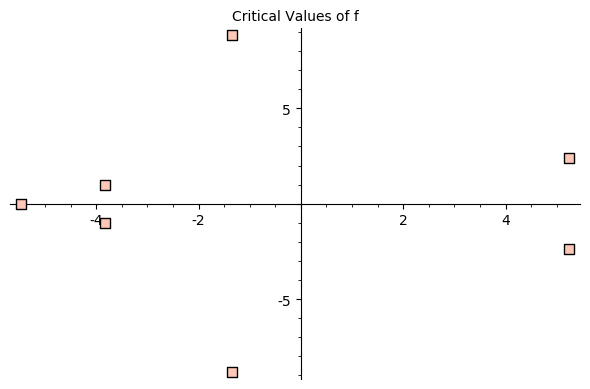

In [5]:
plot_points = [(value.real(), value.imag()) for value in crit_values_f]

scatter_plot(plot_points, marker='s', title="Critical Values of f")

## Determining a matching path

In [6]:
# Choice of regular fibre. In this case, 0 is a regular fibre.


fibre_t = f.get_fibre(t, y)[0].simplify()
fibre_0 = fibre_t.subs(t==0)

In [27]:
# Define the bifibration on a regular fibre

rho = LefschetzFibration([x, y, z, a], fibre_0, -3*x+z)
crit_points_rho = rho.get_critical_points()
crit_values_rho = rho.get_critical_values()

print(f'points: {len(crit_points_rho)}, values: {len(crit_values_rho)}')

points: 6, values: 6


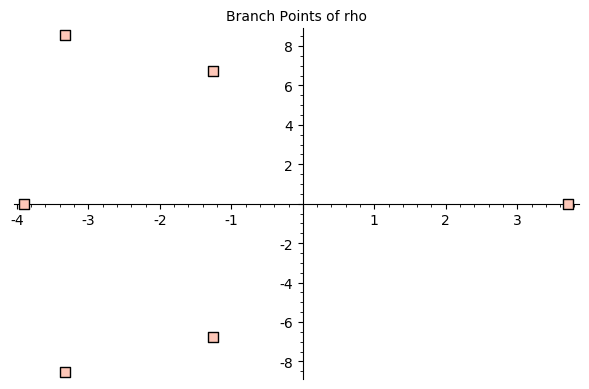

In [28]:
plot_points = [(value.real(), value.imag()) for value in crit_values_rho]
scatter_plot(plot_points, marker='s', title='Branch Points of rho')

In [50]:
matching_critical_value = 6 # Choose the index of the corresponding critical value of f to which we study a matching path

In [51]:
matching_path = {}
for s in np.linspace(0,1,71):
    fibre_s = fibre_t.subs(t==s*crit_values_f[matching_critical_value])
    rho_s = LefschetzFibration([x, y, z, a], fibre_s, rho.fibration)
    matching_path[s] = rho_s.get_critical_values()


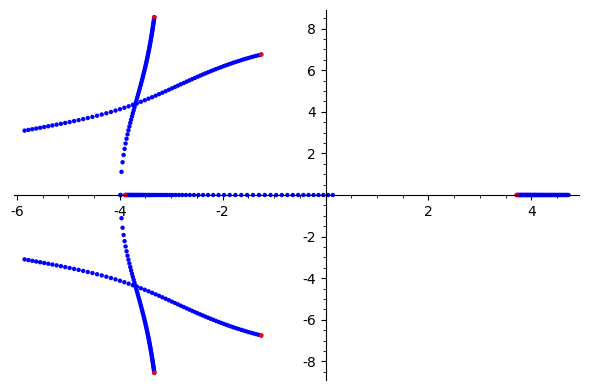

In [52]:
plot_points_highlight = points([(value.real(), value.imag()) for value in matching_path[0]], color='red')



plot_points = points([(value.real(), value.imag()) for crit_values in list(matching_path.values()) for value in crit_values])
plot = plot_points+plot_points_highlight
plot.show()

## Computing the homotopy type of a regular fibre

In [53]:
f.milnor_number(0)

4

In [54]:
rho.milnor_number(0)

2

In [12]:
f.bodin_crit(0)

(y, z, t)


'Polynomial : 1/3y2z-2/3yz2-8/9y2-4/9yz+4/9z2-1\nAffine critical values are the roots of 2187t4+181292t3+664130t2+825900t+340875\nAffine Milnor number : 4\nDetails of affine critical values :\n  2187t3+179105t2+485025t+340875   3  \n  t+1   1  \nCritical values at infinity are the roots of 1\nMilnor number at infinity : 0'

In [49]:
g_eq = x*(x*y -1)
g = LefschetzFibration([x,y, z], z, g_eq )

g.bodin_crit(0)

(z, t)


SingularError: Singular error:
Polynomial : z
Affine critical values are the roots of 1
Affine Milnor number : 0
   ? incompatible type in list assignment
   ? error occurred in or before critic01.lib::iscoordgeneric line 312: `    P = L[2..n];   // Affine polar curve`
   ? leaving critic01.lib::iscoordgeneric
   skipping text from `;` error at token `)`
   ? leaving critic01.lib::critinf
   ? leaving critic01.lib::crit

In [85]:
y, z, t, x0 = var('y, z, t, x0', domain=CC)
f_sage = 1/3*(y - 2*z)*y*z + 1/3*y + 1/3*z + 1

r = singular.ring(0, '(y, z, t, x0)', 'dp')
f = singular.poly('1/3*(y - 2*z)*y*z + 1/3*y + 1/3*z + 1')
fH = singular.poly('1/3*(y-2*z)*y*z + 1/3*y*x0^2 + 1/3*z*x0^2 + x0^3 - t*x0^3')
x0 = singular.poly('x0')

Xf = singular.ideal(fH)
Xinf = singular.ideal(fH, x0)


In [94]:

fH = singular.poly('1/3*(y-2*z)*y*z + 1/3*y*x0^2 + 1/3*z*x0^2 + x0^3 - t*x0^3')
x0 = singular.poly('x0')

Xf = singular.ideal(fH)
Xinf = singular.ideal(fH, x0)

In [2]:
from sage.libs.singular.function import singular_function, lib as singular_lib
singular.eval('LIB "critic01.lib"')

'// ** loaded critic01.lib (0.01,2002/02/11")'

In [3]:
singular.eval('ring R=0,(y, z, t),dp')
singular.eval('poly f=1/3*(y - 2*z)*y*z + 1/3*y + 1/3*z + 1')
# f = singular.poly('1/3*(y - 2*z)*y*z + 1/3*y + 1/3*z + 1')


''

In [6]:
a = singular.eval('crit(f)')


In [10]:
for line in a.split('\n'):
    print(line)

Polynomial : 1/3y2z-2/3yz2+1/3y+1/3z+1
Affine critical values are the roots of 243t4-972t3+1498t2-1052t+279
Affine Milnor number : 4
Details of affine critical values :
  243t4-972t3+1498t2-1052t+279   4  
Critical values at infinity are the roots of 1
Milnor number at infinity : 0


In [91]:
P= [f_sage.diff(var) for var in [y,z]]
P_sing = 

In [93]:
_=singular.lib('critic.lib')

SingularError: Singular error:
   ? cannot open critic.lib
   ? error occurred in or before STDIN line 446: `LIB "critic.lib";`